# Notebook for non-kernel models

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    classification_report,
    make_scorer,
    fbeta_score,
    accuracy_score,
)

from scripts.nested_CV import nested_cv, nested_cv_multi

In [2]:
# configs
seed = 42  # for repeatability

fbeta_scorer = make_scorer(fbeta_score, beta=2, pos_label=-1)
accuracy_scorer = make_scorer(accuracy_score)

score_dict = {"f2": fbeta_scorer, "accuracy": accuracy_scorer}

### Data import and preprocessing

In [ ]:
# data
file_path = "../data/laser.mat"
mat = loadmat(file_path)

X = mat["X"]
y = mat["Y"].reshape(200)

print(X.shape, y.shape)

(200, 60) (200,)


#### Normalization
Z score normalization is applied to each instance. This is done, incase some samples have a different frequency specification, which we don't want our models to learn. Instead we just want to look at the relative $\Delta$ between time stamps.

The zscore normalization is defined as follows:

$$
z = \frac {x - \overset{-}{x}}{\sigma}  \text \space \newline where, \overset{-}{x} = \text{mean} \space and \space \sigma = \text{standard deviation}
$$

In [4]:
# normalizing the data and splitting into train/test splits
X = (X - X.mean(axis=1, keepdims=True)) / X.std(axis=1, keepdims=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed
)

## Baseline: Logistic Regression

### Description
Regression, that uses the sigmoid function as the decision function to classify instances. It uses the logistic loss and we use the L2 penalty here.

Sigmoid function:
$$
f_{\theta}(x) = \frac {1}{1+e^{-x}}
$$

Logistic loss:
$$
\mathcal{l}_{\text log}(f_{\theta (x_{\text i}), y_{\text i}}) = log(1+e^{-y_{i} f_{\theta}(x_{i})})

$$

### Tuning
We tune for the $f_{\beta}$ (formula given below) score of the negative class, with $\beta = 2$ (i.e. recall is twice as important as precision), under the assumption that shipping a medical grade laser is more expensive than re-testing and/or repairing it. Therefore, it's better to identify as many faulty lasers as possible, even if it means re-testing some positive ones. 

$$
f_{\beta} =\frac {\beta^{2} + 1}  {\beta^{2} \cdot recall^{-1} + precision^{-1}} = \frac {1+\beta^{2} \cdot precision \cdot recall} {(\beta^{2} \cdot precision) + recall}
$$

#### Nested Cross Validation
Here is a visual explanation of nested cross validation: <br>
![image](../diagrams/nested.jpg)

The `nested_cv` function performs nested cross validation, with (by default) 5 outer and 5 inner loops and is abstracted away at `src/scripts/nested_CV.py`

In [6]:
param_grid_log = {"C": np.logspace(-3, 3, 7)}
results = nested_cv_multi(
    LogisticRegression(penalty="l2"),
    X,
    y,
    param_grid=param_grid_log,
    scoring=score_dict,
    random_state=seed,
)

print(">>>>RESULTS<<<<")
print(
    "Mean score (of negative class) over 5 by 5 rounds of Nested CV ",
    results["mean_scores"],
)
print("Best parameters ", results["star_params"])

>>>>RESULTS<<<<
Mean f2 score (of negative class) over 5 by 5 rounds of Nested CV  {'f2': 0.9193507586052723, 'accuracy': 0.9199999999999999}
Best parameters  {'C': 0.1}


In [7]:
print(results)

{'outer_scores': [{'f2': 0.8585858585858586, 'accuracy': 0.875}, {'f2': 0.8585858585858586, 'accuracy': 0.875}, {'f2': 0.9900990099009901, 'accuracy': 0.975}, {'f2': 0.9803921568627451, 'accuracy': 0.95}, {'f2': 0.9090909090909091, 'accuracy': 0.925}], 'mean_scores': {'f2': 0.9193507586052723, 'accuracy': 0.9199999999999999}, 'std_scores': {'f2': 0.05695854285956674, 'accuracy': 0.03999999999999999}, 'best_params': [{'C': 1000.0}, {'C': 10.0}, {'C': 0.1}, {'C': 1.0}, {'C': 0.1}], 'star_params': {'C': 0.1}}


In [20]:
clf_log = LogisticRegression(C=0.1)
clf_log.fit(np.delete(X, [35, 162], axis=0), np.delete(y, [35, 162], axis=0))

odd_laser_faulty = clf_log.predict([X[35]])
odd_laser_non_faulty = clf_log.predict([X[162]])
print(odd_laser_faulty, odd_laser_non_faulty)

[-1] [-1]


## BUT ..... 

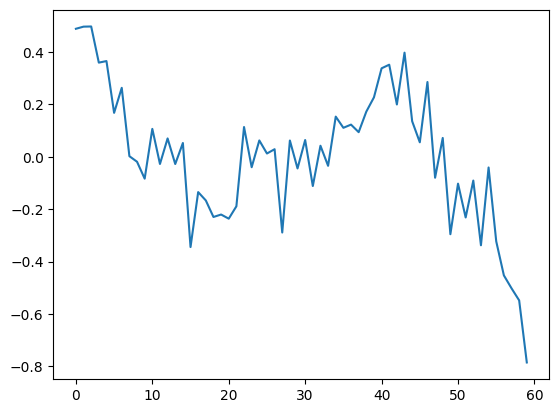

In [22]:
plt.plot(clf_log.coef_[0])